# Setup

 Import standard modules

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import time

Set root directory

In [2]:
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim" / "tides"

Import project modules

In [3]:
from tidal_flat_0d import models
from tidal_flat_0d import features
from tidal_flat_0d import visualization as viz

# Run Model

In [85]:
def aggrade(water_heights, timestep, settle_rate, bulk_dens, bound_conc, init_elev=0, init_conc=0, depth_cutoff=0.001, debug=False):

    def below_platform(t, y, *args):
        depth = tide_spl(t) - (y[1] + depth_cutoff)
        return depth

    below_platform.terminal = True
    below_platform.direction = -1

    def solve_ode(t, y, *args):
        
        # set initial values for concentration and elevation
        init_conc = y[0]
        init_elev = y[1]
        
        # use spline function for tide height to set current water_height
        water_height = tide_spl(t)
        depth = water_height - init_elev #calculate current depth

        # use derivative of tide spline to get current gradient and set H
        dhdt = dhdt_spl(t)

        if dhdt > 0:
            H = 1
        else:
            H = 0
        
        delta_conc = - (settle_rate * init_conc) / depth - H / depth * (init_conc - bound_conc) * dhdt
        delta_elev = settle_rate * (init_conc + delta_conc) / bulk_dens

        return [delta_conc, delta_elev]

    elev = init_elev
    conc = init_conc
    data = pd.Series(water_heights)
    pos = 0
    elevs = np.empty(0)
    concs = np.empty(0)
    times = np.empty(0)
    inundations = 0

    while True:
        remaining_data = data[pos:]
        data_above_platform = remaining_data[remaining_data > (elev + depth_cutoff)]
        
        if len(data_above_platform) < 4:
            break

        if len(np.where(np.diff(data_above_platform.index) != 1)[0]) == 0:
            end = len(data_above_platform)
        else:
            end = np.where(np.diff(data_above_platform.index) != 1)[0][0] + 1
        
        
        subset = data_above_platform[:end]

        if len(subset) < 4:
            pos = end + 1
            continue
            
        subset = pd.Series(data=subset.values, index=pd.timedelta_range(start=0, periods=len(subset), freq=timestep))
        subset = subset.resample(rule='1s').interpolate(method='linear')
        subset = pd.Series(data=subset.values, index=np.arange(0, len(subset)))

        tide_spl = InterpolatedUnivariateSpline(subset.index, subset)
        dhdt_spl = tide_spl.derivative()

        t_span = [subset.index[0], subset.index[-1]]
        result = solve_ivp(fun=solve_ode, t_span=t_span, y0=[conc, elev], events=below_platform,
                               args=(bound_conc, settle_rate, bulk_dens, depth_cutoff, timestep), dense_output=True)
        if result.status == -1:
            print(result.message)
            break
        
        times = np.concatenate((times, result.t / timestep.delta.total_seconds() + pos))
        concs = np.concatenate((concs, result.y[0]))
        elevs = np.concatenate((elevs, result.y[1]))

        elev = result.y[1][-1]
        inundations += 1
        pos = end + 1

    return [times, concs, elevs]

In [111]:
# Load Tides
tide_dt = 30
tide_name = "tides-debug-{}s.feather".format(tide_dt)
# tide_name = 'tides-1yr-{}s.feather'.format(tide_dt)
tides = features.load_tide(wdir, tide_name)
tides = pd.Series(data=tides.pressure.values, index=pd.DatetimeIndex(data=tides.index.values, freq="infer"))
timestep = tides.index.freq

# turn data into series with numeric index
data = pd.Series(tides.values)

# Set grain parameters and settling velocity
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650
settle_rate = models.stokes_settling(grain_dia=grain_dia, grain_den=grain_den)

# Set basic model parameters
bound_conc = 0.8
bulk_dens = 1100
depth_cutoff = 0.001
init_elev = 0
reps = 1
slr = 0 # SLR increase per rep

# Tide function for plotting tides
tide_spl = InterpolatedUnivariateSpline(np.arange(0, len(data)), data)
dhdt_spl = tide_spl.derivative()

In [112]:
times = np.empty(0)
concs = np.empty(0)
elevs = np.empty(0)
elev = init_elev
water_heights = data.values
start_time = time.perf_counter()
for rep in range(0, reps):
    water_heights = water_heights + (rep * slr)
    t, c, z = aggrade(water_heights=water_heights, settle_rate=settle_rate, bulk_dens=bulk_dens, 
                               bound_conc=bound_conc, init_elev=elev, init_conc=0, timestep=timestep, depth_cutoff=depth_cutoff)
    times = np.concatenate((times, t))
    concs = np.concatenate((concs, c))
    elevs = np.concatenate((elevs, z))
    elev = elevs[-1]
end_time = time.perf_counter()

print('Total accumulation: {:f} cm'.format((elev - init_elev) * 100))
print('Final Elevation: {:.4f} m'.format(elev))
print('Simulation completed in {:.0f} s'.format(end_time - start_time))

Total accumulation: 0.102691 cm
Final Elevation: 0.0010 m
Simulation completed in 0 s


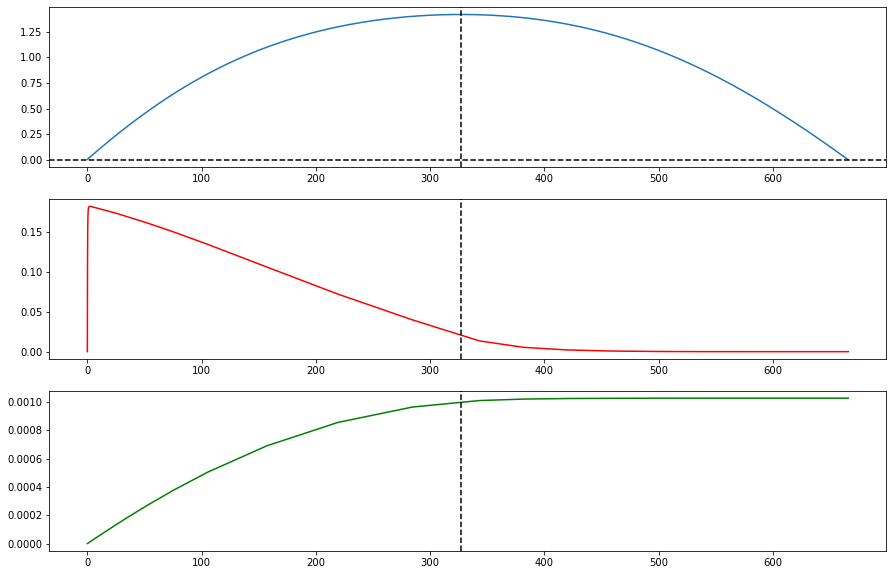

In [113]:
plt_data = data
t = times
c = concs
z = elevs

slack = plt_data.index.values[np.where(dhdt_spl(plt_data.index) < 0)[0][0]]
fig, axs = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0].plot(plt_data)
axs[0].axhline(elev + depth_cutoff, ls='--', color='black')
axs[1].plot(t, c, color='r')
axs[2].plot(t, z, color='g')
for ax in axs:
    ax.axvline(slack, ls='--', color='black')